<a href="https://colab.research.google.com/github/sakib7/ml-project-versioning/blob/main/lstm_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
url = "https://raw.githubusercontent.com/sakib7/IT00CD79-3005-Machine-Learning/main/Sentiment140.tenPercent.sample.tweets.tsv"
dataset = pd.read_csv(url, delimiter="\t")
dataset['sentiment'] = dataset['sentiment_label'].replace(4,1)
dataset['text'] = dataset['tweet_text']
dataset = dataset.drop(columns=['tweet_text', 'sentiment_label'])
# print(dataset.head(10))
dataset

,sentiment,text
0,1,"@elephantbird Hey dear, Happy Friday to You A..."
1,1,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,1,@Covergirl08 I take pride in what I do
159998,1,heading to work on the 6


In [ ]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('https://raw.githubusercontent.com/sakib7/IT00CD79-3005-Machine-Learning/main/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [ ]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 10 s, sys: 43.3 ms, total: 10.1 s
Wall time: 10.6 s


In [ ]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @elephantbird Hey dear, Happy Friday to You  Already had your rice's bowl for lunch ?
Processed: <user> hey dear  happy friday to you  already had your riceis bowl for lunch  
Text: Ughhh layin downnnn    Waiting for zeina to cook breakfast
Processed: ughh layin downn  waiting for zeina to cook breakfast
Text: @greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him. 
Processed: <user> i reckon he will play  even if he is not 100   but i know nothing   <smile> it will not be the same without him  
Text: @vaLewee I know!  Saw it on the news!
Processed: <user> i know   saw it on the news 
Text: very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years 
Processed: very sad that <url> has closed down  one of the few web services that i have used for over 5 years 
Text: @Fearnecotton who sings 'I Remember'? i alwaysss hear it on Radio 1 but never catch the artist 
Proc

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [ ]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 13715
CPU times: user 22.2 s, sys: 164 ms, total: 22.4 s
Wall time: 13.3 s


In [ ]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)
tokenizer.word_index['love']

Tokenizer vocab length: 60000


50

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print(X_train[10:15])
print(X_train_sequences[10:15])

['<user> yet again  a diss goes rght past u dork   and how the hell did u get more followers  meanie'
 'i have a sad feeling that dallas is not going to show up  i got to say though  you would think more shows would use music from the game  mm'
 '<user>  glad to hear that you have great friends kyanna  im sorry to hear about your family'
 'what am i going to do  my ipod is dying     nowhere near a charger'
 '<user> they are trying to confuse you  and it seems to work  ']
[[3, 211, 109, 6, 9809, 522, 28346, 730, 57, 4161, 9, 71, 5, 453, 69, 57, 38, 88, 389, 5206], [2, 17, 6, 113, 183, 21, 2612, 7, 12, 35, 4, 173, 34, 2, 44, 4, 168, 131, 11, 103, 80, 88, 842, 103, 360, 328, 56, 5, 308, 651], [3, 273, 4, 266, 21, 11, 17, 102, 200, 48230, 62, 121, 4, 266, 61, 48, 340], [59, 16, 2, 35, 4, 24, 8, 626, 7, 1004, 2090, 1012, 6, 2205], [3, 77, 27, 224, 4, 6491, 11, 9, 10, 490, 4, 49]]


In [ ]:
X_train = pad_sequences(X_train_sequences, maxlen=input_length)
X_test  = pad_sequences(X_test_sequences , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)
X_train[10], X_test[10]

X_train.shape: (152000, 60)
X_test.shape : (8000, 60)


(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     3,   211,   109,     6,  9809,
          522, 28346,   730,    57,  4161,     9,    71,     5,   453,
           69,    57,    38,    88,   389,  5206], dtype=int32),
 array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     3,    41,  2964, 38977], dtype=int32))

In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)
embedding_matrix[50]

Embedding Matrix Shape: (60000, 100)


array([ 0.06647149,  1.06174803, -0.03678437, -0.84724236,  1.64280438,
       -0.34288791, -0.4195652 ,  0.26399198,  1.11278331, -1.71966708,
       -0.39004898, -0.68750858, -0.93489891, -0.53773481,  0.40099534,
        2.27056336,  0.86165196,  0.4483684 , -0.15474348, -0.63772488,
        0.15852991,  0.07599661, -0.44814572,  0.13434026, -1.30838752,
        1.79257905, -0.59934521,  0.89682007, -0.72760022, -1.8362366 ,
        0.30533251, -0.23506212,  0.32554629, -1.55721557, -0.69303572,
        0.94033056,  0.2473571 ,  2.34108114,  2.12909365, -0.61892575,
        0.04845851,  0.9250139 , -0.06398524, -1.23203337, -0.97679305,
        1.48465645,  1.36513817, -0.37471178,  1.38926542,  0.85662913,
       -0.12294748, -0.48948282,  1.35671663, -0.38509193,  1.11961603,
        2.65155292, -0.54077756,  0.59383237, -2.29530573, -0.50379705,
        0.75357556,  0.56266874,  0.76589715,  1.91072631,  0.41445306,
       -0.85650772,  0.84288311,  1.41131318, -0.38395381,  1.57

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [ ]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        LSTM(64, dropout=0.3, return_sequences=True),
        # Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)),
        # Conv1D(64, 5, activation='relu'),
        GlobalMaxPool1D(),
        # Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model


In [ ]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 lstm (LSTM)                 (None, 60, 64)            42240     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6042305 (23.05 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 6000000 (22.89 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/7
268/268 [==============================] - 76s 275ms/step - loss: 0.5465 - accuracy: 0.7217 - val_loss: 0.4966 - val_accuracy: 0.7570 - lr: 0.0010
Epoch 2/7
268/268 [==============================] - 70s 263ms/step - loss: 0.5007 - accuracy: 0.7540 - val_loss: 0.4762 - val_accuracy: 0.7676 - lr: 0.0010
Epoch 3/7
268/268 [==============================] - 71s 265ms/step - loss: 0.4863 - accuracy: 0.7628 - val_loss: 0.4681 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 4/7
268/268 [==============================] - 72s 268ms/step - loss: 0.4767 - accuracy: 0.7704 - val_loss: 0.4624 - val_accuracy: 0.7791 - lr: 0.0010
Epoch 5/7
268/268 [==============================] - 71s 265ms/step - loss: 0.4696 - accuracy: 0.7745 - val_loss: 0.4572 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 6/7
268/268 [==============================] - 70s 263ms/step - loss: 0.4640 - accuracy: 0.7784 - val_loss: 0.4503 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 7/7
268/268 [==============================] - 69s 2

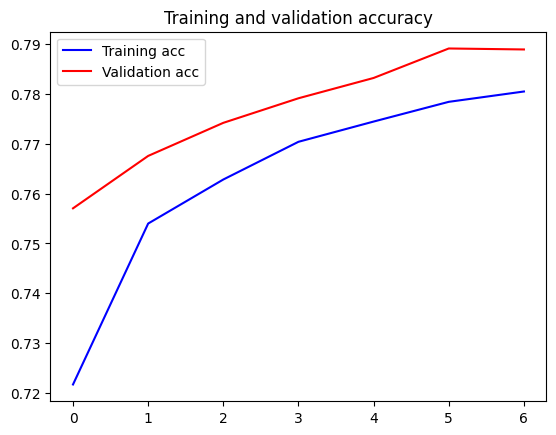

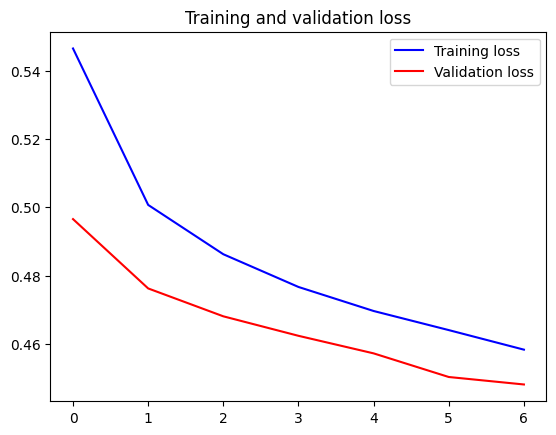

250/250 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4061
           1       0.79      0.80      0.80      3939

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000

CPU times: user 12min 32s, sys: 37.8 s, total: 13min 10s
Wall time: 8min 25s


In [ ]:
%%time

history = training_model.fit(
    X_train, y_train,
    batch_size=512,
    epochs=7,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

from sklearn.metrics import confusion_matrix, classification_report

y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

print(classification_report(y_test, y_pred))